Visualizing Covid-19 data for major EU economies

Reading time: ~10 min 

Introductioo

Dear reader,

In this notebook, I am happy to present the insights I found analyzing Covid-19 data. The goal of this project was to turn raw numbers into meaningful visual representations, discuss them and derive conclusions. There are many ways how one can play with the data, so the work you are reading at the moment may partially reflect my personal view on the topic. Anyway, I hope you will learn something new and useful, and have a joyful time reading this notebook.

The notebook is structured the following way:

Section 1: Extracting and processing the data.
Section 2: Visualizing the data
Session 3: Discussion of the results
Session 4: Conclusion

In case you are not interested in the technical implementation, I suggest skipping first two sections and going straight for the Section 3.

Enjoy:-)

Section 1

In this section, you will be able to see the code used to extract and process the data. The code isn't tailored for any specific country and can be used to extract and process any kind of data. I tried to make it clear and intuitive, so you shouldn't get in trouble reading it. Also, I provided some comments that are ment to explain the purpose of each fuction.

Preparation

First, I import all the necessary packages:

Requests - Python HTTP package for sending web requests
Datetime - Python module for working with dates and time
Pandas - Python software library for data manipulation and analysis
Matplotlib - Python library for data visualization
Numpy - Python package for scientific computing

Also, I allow Matplotlib to print the graphs within the notebook and change rastor graphics to vector.

In [1]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='svg'

The code bellow configures pandas

In [2]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', None)

and stores the colors for each country in a Python dictionary.

In [3]:
design = {'Spain': '#FDD835', 'Italy': '#43A047', 'France': '#1E88E5', 'United Kingdom': '#E53935', 'Germany': '#BA68C8'}

Functions

I primarily used two resources to access the data:

For time series analysis I extracted the data from an API kindly provided by the [Johns Hopkins CSSE](https://covid19api.com/).
For static analysis, I accessed data through the [NovelCOVID API](https://github.com/javieraviles/covidAPI).

Both API are recommended by the [Postman COVID-19 API Resource Center](https://covid-19-apis.postman.com/).

Function timeSeriesInstructions() is used to view the instuctions for the [Johns Hopkins CSSE API](https://covid19api.com/). It doesn't take any arguments and it returns pandas dataframe with the instructions.

In [4]:
def timeSeriesInstructions():
    
    r = requests.get('https://api.covid19api.com/')
    instructions_dic = r.json()
    instructions = pd.DataFrame.from_dict(instructions_dic).transpose()
    
    return instructions

Function filterDate(data, start_date, end_date) accepts time series dataframe and a date range, and truncates the data in respect to the specified time period.

In [5]:
def filterDate(data, start_date = '2020-03-01', end_date = '2020-04-30'):
    
    filter_start_date = data['Date'] >= start_date
    filter_end_date = data['Date'] < end_date
    data = data[filter_start_date & filter_end_date]
    
    return data

Function timeSeriesData(list_countries) accepts a list with country names and returns grouped time series data for the selected countries.

In [6]:
def timeSeriesData(list_countries = ['italy', 'spain', 'france']):

    data = []

    for country in list_countries:
        r = requests.get(f'https://api.covid19api.com/country/{country}')
        data_dic = r.json()
        raw_data = pd.DataFrame.from_dict(data_dic)

        filter_province = raw_data['Province'] != ''
        raw_data.drop(index = raw_data[filter_province].index, inplace = True)

        filter_columns = ['CountryCode', 'Province', 'City', 'CityCode', 'Lat', 'Lon', 'Active']
        raw_data.drop(columns = filter_columns, inplace = True)

        raw_data['Date'] = pd.to_datetime(raw_data['Date'], format = '%Y-%m-%dT%H:%M:%SZ')
        
        numeric_columns = ['Confirmed', 'Deaths', 'Recovered']
        raw_data[numeric_columns] = raw_data[numeric_columns].apply(pd.to_numeric)

        data.append(raw_data)

    data = pd.concat(data)

    column_names = ['Country', 'Date', 'Confirmed', 'Deaths', 'Recovered']
    data = data.reindex(columns = column_names)

    data = filterDate(data)
    country_group = data.groupby('Country')    

    return country_group

Function pickCountry(country_group, country_name) accepts grouped dataframe and a country name and returns time series data for the selected country.

In [7]:
def pickCountry(country_group, country_name):
    
    country_name = country_name.title()
    ts_data = country_group.get_group(country_name)
    ts_data.reset_index(drop = True, inplace = True)
    
    return ts_data

Function dailyChanges(ts_data, prc = False, periods = 1) accepts time series data for a particular country and converts it into changes overtime. Changes can be viewed in absolute (pct = False) or in relative terms (pct = True) and over various number of periods (ex. to see weekly changes: periods = 7). 

In [8]:
def dailyChanges(ts_data, prc = False, periods = 1):
    numeric_columns = ['Confirmed', 'Deaths', 'Recovered']
    legend_data = ts_data[['Country', 'Date']]

    if (prc):
        change_data = round(100 * ts_data[numeric_columns].pct_change(periods = periods), 2)
        change_data.replace([np.inf, np.nan], 0, inplace = True)
    else:
        change_data = ts_data[numeric_columns].diff(periods = periods)
        change_data.replace([np.inf, np.nan], 0, inplace = True)
        change_data = change_data.astype(int)

    diff_data = pd.concat([legend_data, change_data], axis = 1)
    
    upper_bound = diff_data.index[:periods]
    diff_data.drop(labels = upper_bound, axis = 0, inplace = True)
    
    diff_data.reset_index(drop = True, inplace = True)

    return diff_data

Function crossSectionalData() doesn't take and arguments and is used to extract cross sectional data from the [NovelCOVID API](https://github.com/javieraviles/covidAPI).

In [9]:
def crossSectionalData():
    
    r = requests.get('https://coronavirus-19-api.herokuapp.com/countries')
    cs_data_dic = r.json()
    cs_data = pd.DataFrame.from_dict(cs_data_dic)
    
    cs_data = cs_data.loc[1:]
    
    cs_data = cs_data.apply(pd.to_numeric, errors = 'ignore')
    cs_data.sort_values('cases', ascending = False, inplace = True)
    
    cs_data['Population (M)'] = round((cs_data['cases'] / cs_data['casesPerOneMillion']), 2)
    
    cs_data['Population (M)'].replace([np.inf, 0], np.nan, inplace = True)
    cs_data.dropna(axis = 0, subset = ['Population (M)'], inplace = True)
    
    filter_columns = ['todayCases', 'todayDeaths', 'active', 'critical', 
                      'casesPerOneMillion', 'deathsPerOneMillion', 'testsPerOneMillion']
    cs_data.drop(columns = filter_columns, inplace = True)
    
    cs_data.columns = cs_data.columns.str.title()
    cs_data.rename(columns = {'Totaltests': 'Tested'}, inplace = True)
    cs_data.reset_index(drop = True, inplace = True)
    
    return cs_data

Function aggregatedCrossSectionalData(number_of_countries, include_other) is used to aggreagte the data. First argument specifies the number of countries to leave untouched. Second argument determines whether to include aggregated data into the dataframe.

In [10]:
def aggregatedCrossSectionalData(number_of_countries, include_other = True):
    
    cs_data = crossSectionalData()
    lower_bound = number_of_countries + 1
    
    agg_part = cs_data.iloc[lower_bound:]
    non_agg_part = cs_data.iloc[:number_of_countries] 
    
    other_row = agg_part.sum(numeric_only=True)
    other_row['Country'] = 'Other countries'
    
    if (include_other):
        agg_data = non_agg_part.append(other_row, ignore_index=True)
    else:
        agg_data = non_agg_part
        
    return agg_data


Next three functions are ment to test the functionality of the code written above.

In [11]:
def testTimeSeriesInstructions():
    
    try:
        instructions = timeSeriesInstructions()
        assert instructions.empty == False
        print("Congrats, tests for timeSeriesInstructions() function have been passed.")
    except:
        print('Assertion error detected. Please, inspect timeSeriesInstructions() function.')


In [12]:
def testTimeSeriesData():
    
    test = timeSeriesData()
    test = pickCountry(test, 'Latvia')
    
    try:
        assert test['Date'].iloc[0] == datetime.strptime('2020-03-01', '%Y-%m-%d')
        assert list(test.columns) == ['Country', 'Date', 'Confirmed', 'Deaths', 'Recovered']
        assert type(test['Confirmed'].iloc[0]) == np.int64        
        print("Congrats, tests for timeSeriesData() function have been passed.")       
    except:
        print('Assertion error detected. Please, inspect timeSeriesData() function.')
        
    test_diff = dailyChanges(test, prc = False)
    test_pct = dailyChanges(test, prc = True)
    
    max_index = len(test['Confirmed']) - 1
    index = np.random.randint(low = 1, high = max_index)
    calculation_pct = round(100 * (test['Confirmed'].iloc[index]/test['Confirmed'].iloc[index-1] - 1), 2)
    if (calculation_pct == np.inf) or (calculation_pct == np.nan):
        calculation_pct = 0
        
    calculation_diff = test['Confirmed'].iloc[index] - test['Confirmed'].iloc[index - 1] 
        
    try:    
        assert calculation_pct == test_pct['Confirmed'].iloc[index-1]
        assert calculation_diff == test_diff['Confirmed'].iloc[index-1]
        print("Congrats, tests for dailyChanges() function have been passed.")        
    except:
        print('Assertion error detected. Please, inspect dailyChanges() function.')   


In [13]:
def testCrossSectionalData():
    
    test = crossSectionalData()
    
    upper_bound = len(test['Cases']) - 1
    number_of_countries = np.random.randint(low = 0, high = upper_bound)
    
    try:
        assert list(test.columns) == ['Country', 'Cases', 'Deaths', 'Recovered', 'Tested', 'Population (M)']
        assert type(test['Cases'].iloc[0]) == np.int64
        print('Congrats, tests for crossSectionalData() function have been passed.')
    except:
        print('Assertion error detected. Please, inspect crossSectionalData() function.')
        
    test_top = aggregate(number_of_countries, False)
    test_agg = aggregate(number_of_countries, True)
    
    try:
        assert len(test_top['Cases']) == number_of_countries
        assert len(test_agg['Cases']) == number_of_countries + 1
        print('Congrats, tests for aggregatedCrossSectionalData() function have been passed.')
    except:
        print('Assertion error detected. Please, inspect aggregatedCrossSectionalData() function.')
  

Section 2

In this section, you will be able to explore the functions used to visualize the data. Unlike in the previous section, the code bellow is tailored for analizing specific countries: Spain, Italy, France, Germany and the United Kingdom. However, most of the expressions aren't country specific, so with few easy changes the code can be reused for analyzing other countries as well. Please, feel free to use the code bellow (and above:-)) to play around with the data on your own.

Function stackPlot() creates a stack plot for Covid-19 confirmed cases in major EU economies.

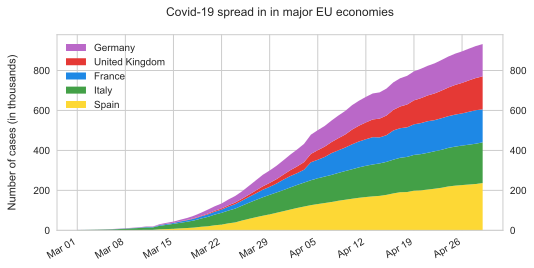

In [33]:
def stackPlot():
    
    data = timeSeriesData(['spain', 'italy', 'france', 'germany', 'united-kingdom'])
    
    plt.style.use('seaborn-whitegrid')
    plt.rcParams['figure.figsize'] = (8, 4)
    
    spain = pickCountry(data, 'Spain')
    italy = pickCountry(data, 'Italy')
    france = pickCountry(data, 'France')  
    germany = pickCountry(data, 'Germany')
    uk = pickCountry(data, 'United Kingdom')
    
    x_axis = spain['Date']
    
    y_axis1 = spain['Confirmed'] / 1000 
    y_axis2 = italy['Confirmed'] / 1000
    y_axis3 = france['Confirmed'] / 1000
    y_axis4 = uk['Confirmed'] / 1000
    y_axis5 = germany['Confirmed'] / 1000
    
    labels = ['Spain', 'Italy', 'France', 'United Kingdom', 'Germany']
    colors = list(design.values())
    
    fig, ax = plt.subplots()
    
    fig.autofmt_xdate()
    ax.stackplot(x_axis, y_axis1, y_axis2, y_axis3, y_axis4, y_axis5, labels=labels, colors = colors)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc = 'upper left')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
    ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
    
    ax.set_title('Covid-19 spread in in major EU economies\n')
    ax.set_ylabel('Number of cases (in thousands)\n')
    plt.tick_params(labelright=True)
    
    plt.show()
    
stackPlot()

Function plotMajorEUEconomies() creates 2 simple plots for major EU economies: one based on Covid-19 confirmed cases, another based on deaths caused by Covid-19.

In [31]:
def plotMajorEUEconomies():

    data = timeSeriesData(['spain', 'italy', 'france', 'germany', 'united-kingdom'])
    
    plt.style.use('seaborn-whitegrid')
    plt.rcParams['figure.figsize'] = (6, 6)
    
    spain = pickCountry(data, 'Spain')
    italy = pickCountry(data, 'Italy')
    france = pickCountry(data, 'France')  
    germany = pickCountry(data, 'Germany')
    uk = pickCountry(data, 'United Kingdom')
    
    x_axis = spain['Date']
    
    y_axis1 = spain['Deaths'] / 1000 
    y_axis2 = italy['Deaths'] / 1000
    y_axis3 = france['Deaths'] / 1000
    y_axis4 = uk['Deaths'] / 1000
    y_axis5 = germany['Deaths'] / 1000
    y_axis6 = spain['Confirmed'] / 1000 
    y_axis7 = italy['Confirmed'] / 1000
    y_axis8 = france['Confirmed'] / 1000
    y_axis9 = uk['Confirmed'] / 1000
    y_axis10 = germany['Confirmed'] / 1000
    
    labels = ['Spain', 'Italy', 'France', 'United Kingdom', 'Germany']
    colors = list(design.values())
    
    fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1)
    
    fig.autofmt_xdate()
    
    ax1.plot(x_axis, y_axis1, label=labels[0], color = colors[0])
    ax1.plot(x_axis, y_axis2, label=labels[1], color = colors[1])
    ax1.plot(x_axis, y_axis3, label=labels[2], color = colors[2])
    ax1.plot(x_axis, y_axis4, label=labels[3], color = colors[3])
    ax1.plot(x_axis, y_axis5, label=labels[4], color = colors[4])
    
    ax1.legend(loc = 'upper left')
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(7))
    ax1.xaxis.set_major_formatter(DateFormatter('%b %d'))
    
    ax1.set_title('Deaths caused by Covid-19 in major EU economies\n')
    ax1.set_ylabel('Number of deaths (in thousands)\n')
    ax1.tick_params(labelright = True)
   
    ax2.plot(x_axis, y_axis6, label=labels[0], color = colors[0])
    ax2.plot(x_axis, y_axis7, label=labels[1], color = colors[1])
    ax2.plot(x_axis, y_axis8, label=labels[2], color = colors[2])
    ax2.plot(x_axis, y_axis9, label=labels[3], color = colors[3])
    ax2.plot(x_axis, y_axis10, label=labels[4], color = colors[4])
    
    ax2.legend(loc = 'upper left')
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(7))
    ax2.xaxis.set_major_formatter(DateFormatter('%b %d'))
    
    ax2.set_title('Confirmed Covid-19 cases in major EU economies\n')
    ax2.set_ylabel('Number of cases (in thousands)\n')
    ax2.tick_params(labelright=True)
    
    ax1.fill_between(x_axis, y_axis5, y_axis4, where = (y_axis5 < y_axis4), 
                     interpolate=True, color='green', alpha=0.09, label='German healthcare?')
    plt.figtext(0.75, 0.68, 'German\nhealthcare?')
    
    plt.tight_layout()
    plt.show()

Function dailyCases() plots the number for daily Covid-19 confirmed cases and the daily percentage increase of the total number of confirmed cases for each of the major EU economies.

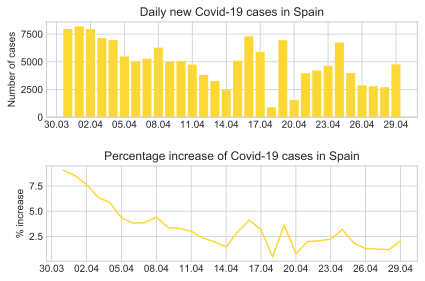

***************************************************************************


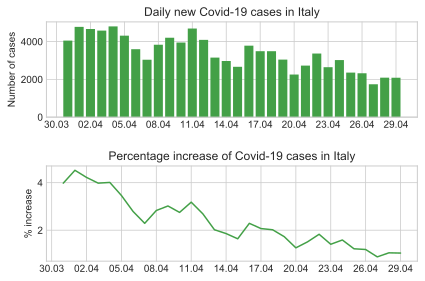

***************************************************************************


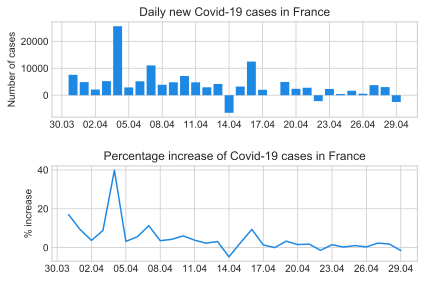

***************************************************************************


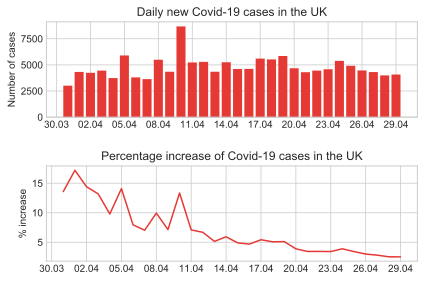

***************************************************************************


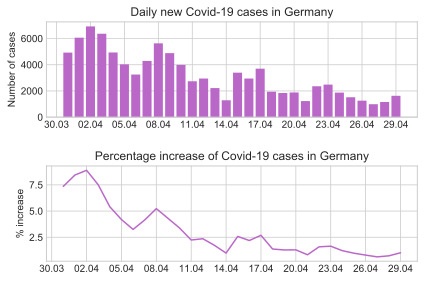

***************************************************************************


In [16]:
def dailyCases():

    country_list = ['spain', 'italy', 'france', 'united-kingdom', 'germany']
    colors = list(design.values())
    
    data = timeSeriesData(country_list)
    
    plt.style.use('seaborn-whitegrid')
    plt.rcParams['figure.figsize'] = (6, 4)
    
    for country, color in zip(country_list, colors):
        if (country == 'united-kingdom'):
            country = 'United Kingdom'
    
        ts_data = pickCountry(data, country)
        daily_cases = dailyChanges(ts_data, prc = False)
        daily_pct = dailyChanges(ts_data, prc = True)
        
        month_ago = len(daily_cases['Date']) - 30
        
        x_axis1 = daily_cases['Date'].iloc[month_ago:]
        x_axis2 = daily_cases['Date'].iloc[month_ago:]
        
        y_axis1 = daily_cases['Confirmed'].iloc[month_ago:] 
        y_axis2 = daily_pct['Confirmed'].iloc[month_ago:] 
        
        fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False)
        
        ax1.bar(x_axis1, y_axis1, color = color)
        ax2.plot(x_axis2, y_axis2, color = color)
        
        ax1.xaxis.set_major_locator(ticker.MultipleLocator(3))
        ax1.xaxis.set_major_formatter(DateFormatter('%d.%m'))
        
        ax2.xaxis.set_major_locator(ticker.MultipleLocator(3))
        ax2.xaxis.set_major_formatter(DateFormatter('%d.%m'))
        
        if (country == 'United Kingdom'):
            country = 'the UK'
        else:
            country = country.title()
        
        ax1.set_title(f'Daily new Covid-19 cases in {country}')
        ax1.set_ylabel('Number of cases')
        # ax1.tick_params(labelright = True)
        
        ax2.set_title(f'\nPercentage increase of Covid-19 cases in {country}')
        ax2.set_ylabel('% increase')
        # ax2.tick_params(labelright = True)
        
        plt.tight_layout()
        plt.show()
        
        print('***************************************************************************')

Function distributionByCountry() displays the total number of Covid-19 confirmed cases and their distibution by country.

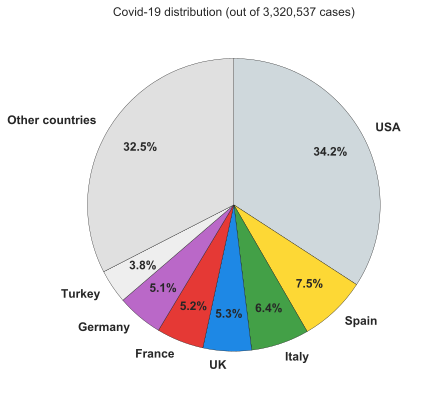

In [19]:
def distributionByCountry():

    data = aggregatedCrossSectionalData(7, include_other = True)
    
    r = requests.get('https://coronavirus-19-api.herokuapp.com/countries')
    summary = r.json()
    summary  = pd.DataFrame.from_dict(summary )
    total = str(summary['cases'].iloc[0])
    
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = (6, 6)
    
    slices = data['Cases']
    labels = data['Country']

    colors = ['#CFD8DC'] + list(design.values()) + ['#EEEEEE','#E0E0E0']
    
    plt.pie(slices, labels=labels, colors = colors, startangle=90, 
            autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, 
            counterclock = False, pctdistance = 0.75, textprops = {'fontsize': 12, 'fontweight': 'bold'})
    
    plt.title(f"Covid-19 distribution (out of {total[0]},{total[1:4]},{total[4:]} cases)")
    plt.tight_layout()
    plt.show()

In [ ]:
Function perMillByCountry() displays the Covid-19 data scaled by the population.

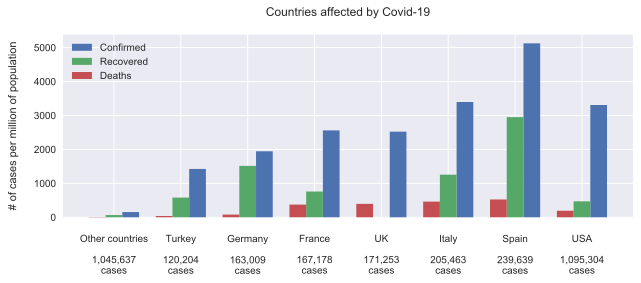

In [27]:
def perMillByCountry():

    data = aggregatedCrossSectionalData(7, include_other = True)
    
    formatting = lambda x: '{:,.0f}'.format(x) 
    data['Legend'] = data['Country'] + '\n\n' + data['Cases'].apply(formatting).astype(str) + '\ncases'
    
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = (9, 4)
    
    x_axis = np.flip(np.arange(len(data['Country'])))
    width = 0.25
    bottom = 1000
    
    y_axis1 = data['Cases'] / data['Population (M)']
    y_axis2 = data['Recovered'] / data['Population (M)']
    y_axis3 = data['Deaths'] / data['Population (M)']   
   
    plt.bar(x_axis + width, y_axis1, width = width, label = 'Confirmed')
    plt.bar(x_axis, y_axis2, width = width, label = 'Recovered')
    plt.bar(x_axis - width, y_axis3, width = width, label = 'Deaths')
    
    plt.xticks(ticks = x_axis, labels = data['Legend'])
    plt.title("Countries affected by Covid-19\n")
    plt.ylabel('# of cases per million of population\n')
    
    plt.tight_layout()
    plt.legend(loc = 'upper left')
    plt.show()

Function scatterByTests() depicts the correlation between the number of Covid-19 recorded cases and the number of tests peformed in a country. 

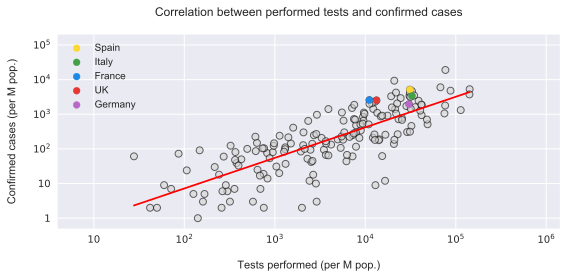

In [25]:
def scatterByTests():
    
    data = crossSectionalData()
    max_countries = len(data['Country'])
    
    data = aggregatedCrossSectionalData(max_countries, include_other = False)
    filter_bias = data['Tested'] == 0
    
    data.drop(index = data[filter_bias].index, inplace = True)

    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = (8, 4)
    
    cases = np.log10(data['Cases'] / data['Population (M)'])
    tests = np.log10(data['Tested'] / data['Population (M)'])
    
    fig, ax = plt.subplots()
    
    a, b = np.polyfit(tests, cases, deg = 1)
    y = lambda x: b + a*x
    
    ax.scatter(tests, cases, edgecolor='black', c = 'lightgrey', linewidth=1, alpha=0.6)
    ax.plot(tests, y(tests), color = 'red') 

    country_list = ['Spain', 'Italy', 'France', 'UK', 'Germany']
    colors = list(design.values())
    countries_legend = []
  
    for country, color in zip(country_list, colors):
                
        filter_country = data['Country'] != country
        country_data = data.drop(index = data[filter_country].index)
        
        country_cases = np.log10(country_data['Cases'] / country_data['Population (M)'])
        country_tests = np.log10(country_data['Tested'] / country_data['Population (M)'])

        country_legend = ax.scatter(country_tests, country_cases, color = color)
        countries_legend.append(country_legend)
    

    ax.set_xticks(ticks = tests)
    ax.set_yticks(ticks = cases)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    ax.set_xticklabels(labels = ['$1$', '$10$','$10^2$','$10^3$','$10^4$','$10^5$','$10^6$'])
    ax.set_yticklabels(labels = ['', '$1$', '$10$','$10^2$','$10^3$','$10^4$','$10^5$']) 

    ax.set_xlim([0.6, 6.15])
    ax.set_ylim([-0.3, 5.3])
    
    ax.set_title('Correlation between performed tests and confirmed cases\n')
    ax.set_xlabel('\nTests performed (per M pop.)')
    ax.set_ylabel('Confirmed cases (per M pop.)\n')
    
    ax.legend(countries_legend, country_list, loc = 'upper left')

    plt.tight_layout()
    plt.show()